In [2]:
import torch
from Retrival_Dino_Salad.model import SaladFaissGPSDB
from preprocess import CampusGPSDataset, GPSRectNorm
import torchvision.transforms.v2 as v2
from private_utils import *
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

import os

DINO_DIR_PATH = "Retrival_Dino_Salad"
DRIVE_MODELS_FOLDER_URL = "https://drive.google.com/drive/folders/18_ALZ-Xdz74LFBQaedxHROuL4Ex0qD-X"
DRIVE_FOLDER_ID = "18_ALZ-Xdz74LFBQaedxHROuL4Ex0qD-X"  

os.makedirs(DINO_DIR_PATH, exist_ok=True)


device: cuda


# Extract Train Test

In [11]:
IMG_MEAN=[0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
from torch.utils.data import DataLoader, random_split 
transform = v2.Compose([
    v2.Resize((4004, 3010), interpolation=v2.InterpolationMode.BILINEAR),
    v2.Resize((686,518), interpolation=v2.InterpolationMode.BILINEAR),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

GPS_norm = GPSRectNorm()
full_dataset = CampusGPSDataset(csv_path="data/photo_locations.csv", image_dir="data/indexed_photos", transform=transform, gps_normalizer=GPS_norm)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Train Phase

### KNN solution

In [3]:
dino_model_knn = torch.hub.load("serizba/salad", "dinov2_salad")

DB_PATH = "trained_models/salad_faiss_db_norm"

try:
    # Try loading existing DB
    db2 = SaladFaissGPSDB.load(DB_PATH, model=dino_model_knn)
    print(f"[OK] Loaded FAISS DB from '{DB_PATH}'")

except (FileNotFoundError, RuntimeError) as e:
    print(f"[INFO] DB not found or invalid ({e}), building new DB...")

    # 1) Build DB
    db = SaladFaissGPSDB(
        dino_model_knn,
        use_cosine=True,
        normalize=True
    )

    db.build_from_loader(train_loader)

    # 2) Save DB
    db.save(DB_PATH)

    # 3) Reload (ensures consistent state)
    db2 = SaladFaissGPSDB.load(DB_PATH, model=dino_model_knn)
    print(f"[OK] Built and saved FAISS DB to '{DB_PATH}'")


Using cache found in /home/yachil/.cache/torch/hub/serizba_salad_main
Using cache found in /home/yachil/.cache/torch/hub/facebookresearch_dinov2_main
/home/yachil/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yachil/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yachil/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


[INFO] DB not found or invalid ([Errno 2] No such file or directory: 'trained_models/salad_faiss_db_norm/data.json'), building new DB...


100%|██████████| 16/16 [02:49<00:00, 10.58s/it]


[OK] Built and saved FAISS DB to 'trained_models/salad_faiss_db_norm'


### DinoMLP solution

In [5]:
from Retrival_Dino_Salad.dinomlp import GPSPredictor, train_dinomlp
dino_model_mlp = torch.hub.load("serizba/salad", "dinov2_salad")
MLP_HEAD_PATH = "trained_models/mlp_head2.pth"
dinoMLP_model = GPSPredictor(dino_model_mlp).to(device)
print("trainable params:", sum(p.numel() for p in dinoMLP_model.parameters() if p.requires_grad))




if os.path.exists(MLP_HEAD_PATH):
    print(f"Found MLP head at {MLP_HEAD_PATH}! Loading...")
    dinoMLP_model.load_state_dict(torch.load(MLP_HEAD_PATH), strict=False)
else:
    dinoMLP_model = train_dinomlp(dinoMLP_model, train_loader, val_loader, epochs=20)
    head_weights = {k: v for k, v in dinoMLP_model.state_dict().items() if "feat_model" not in k}
    torch.save(head_weights, MLP_HEAD_PATH)
    print(f"Model weights saved to {MLP_HEAD_PATH}")


Using cache found in /home/yachil/.cache/torch/hub/serizba_salad_main
Using cache found in /home/yachil/.cache/torch/hub/facebookresearch_dinov2_main


trainable params: 19409922
Found MLP head at trained_models/mlp_head2.pth! Loading...


/tmp/ipykernel_4015104/1801154441.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dinoMLP_model.load_state_dict(torch.load(MLP_HEAD_PATH), strict=False)


### DinoMDN solution

In [5]:
from Retrival_Dino_Salad.dinomdn import GPSPredictorMDN, train_dinomdn
dino_model_mdn = torch.hub.load("serizba/salad", "dinov2_salad")
MDN_HEAD_PATH = "trained_models/mdn_head.pth"
dinoMLP_model = GPSPredictorMDN(dino_model_mdn, GPS_norm).to(device)
print("trainable params:", sum(p.numel() for p in dinoMLP_model.parameters() if p.requires_grad))




if os.path.exists(MDN_HEAD_PATH):
    dinoMLP_model.load_state_dict(torch.load(MDN_HEAD_PATH), strict=False)
else:
    dinoMLP_model = train_dinomdn(dinoMLP_model, train_loader, val_loader, epochs=15)
    head_weights = {k: v for k, v in dinoMLP_model.state_dict().items() if "feat_model" not in k}
    torch.save(head_weights, MDN_HEAD_PATH)
    print("Model weights saved to trained_models/mdn_head.pth")

Using cache found in C:\Users\user1/.cache\torch\hub\serizba_salad_main
Using cache found in C:\Users\user1/.cache\torch\hub\facebookresearch_dinov2_main


trainable params: 77998640


Epoch 01/15 | Train NLL: 114.540933 | Val NLL: 108.953181


Epoch 02/15 | Train NLL: 44.300102 | Val NLL: 1.842258


Epoch 03/15 | Train NLL: 13.014374 | Val NLL: 33.285374


Epoch 04/15 | Train NLL: 20.631904 | Val NLL: 19.215936


Epoch 05/15 | Train NLL: 9.163008 | Val NLL: 4.066736


Epoch 06/15 | Train NLL: 5.880668 | Val NLL: 11.207471


Epoch 07/15 | Train NLL: 12.313687 | Val NLL: 4.050790


Epoch 08/15 | Train NLL: 6.283922 | Val NLL: 2.344169


Epoch 09/15 | Train NLL: 8.848142 | Val NLL: 4.261793


Epoch 10/15 | Train NLL: 3.789845 | Val NLL: 0.856397


Epoch 11/15 | Train NLL: 2.645054 | Val NLL: 0.455365


Epoch 12/15 | Train NLL: 3.069360 | Val NLL: 2.222888


KeyboardInterrupt: 

# Load Models

In [ ]:
# pip install google-api-python-client google-auth google-auth-oauthlib google-auth-httplib2
import os
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

DINO_DIR_PATH = "modles"
DRIVE_FOLDER_ID = "18_ALZ-Xdz74LFBQaedxHROuL4Ex0qD-X"

CREDENTIALS_JSON = "credentials.json"  
TOKEN_JSON = "token.json"              

SCOPES = ["https://www.googleapis.com/auth/drive.file"]

def get_drive_client():
    creds = None
    if os.path.exists(TOKEN_JSON):
        creds = Credentials.from_authorized_user_file(TOKEN_JSON, SCOPES)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CREDENTIALS_JSON, SCOPES)
            creds = flow.run_local_server(port=0)
        with open(TOKEN_JSON, "w") as f:
            f.write(creds.to_json())

    return build("drive", "v3", credentials=creds)

def find_file(drive, folder_id, filename):
    q = f"'{folder_id}' in parents and name='{filename}' and trashed=false"
    res = drive.files().list(q=q, fields="files(id,name)").execute()
    files = res.get("files", [])
    return files[0] if files else None

def upload_file(drive, folder_id, local_path, drive_name=None):
    drive_name = drive_name or os.path.basename(local_path)

    if not os.path.exists(local_path):
        raise FileNotFoundError(local_path)

    existing = find_file(drive, folder_id, drive_name)
    media = MediaFileUpload(local_path, mimetype="application/octet-stream", resumable=True)

    if existing:
        drive.files().update(fileId=existing["id"], media_body=media).execute()
        print(f"✅ Updated on Drive: {drive_name}")
    else:
        meta = {"name": drive_name, "parents": [folder_id]}
        drive.files().create(body=meta, media_body=media, fields="id").execute()
        print(f"✅ Uploaded to Drive: {drive_name}")

# ---- run upload ----
drive = get_drive_client()

files_to_upload = [
    os.path.join(DINO_DIR_PATH, "dinomlp_head.pth"),
]

for p in files_to_upload:
    upload_file(drive, DRIVE_FOLDER_ID, p)


c:\Users\user1\anaconda3\envs\image2gps\lib\site-packages\google\api_core\_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=484040039226-irt9d8n5ggv3pt9jqr1pe8452loinf0h.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61506%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=qrur0oDmDADzH8hIxG81tMz2bBChGh&access_type=offline
✅ Uploaded to Drive: dinomlp_head.pth


In [ ]:
# pip install gdown
import os
import shutil
import gdown

DINO_DIR_PATH = "trained_models"
DRIVE_MODELS_FOLDER_URL = "https://drive.google.com/drive/folders/18_ALZ-Xdz74LFBQaedxHROuL4Ex0qD-X"

TMP_DL_DIR = "_tmp_drive_models_download"
os.makedirs(DINO_DIR_PATH, exist_ok=True)

# Download folder (public)
if not os.path.exists(TMP_DL_DIR):
    gdown.download_folder(
        url=DRIVE_MODELS_FOLDER_URL,
        output=TMP_DL_DIR,
        quiet=False,
        use_cookies=False,
    )

# Copy wanted files into Retrival_Dino_Salad
wanted = ["dinomlp_head.pth", "dinoMLP_gps.pth"]
for fname in wanted:
    # Find file anywhere under TMP_DL_DIR
    found_path = None
    for root, _, files in os.walk(TMP_DL_DIR):
        if fname in files:
            found_path = os.path.join(root, fname)
            break

    if not found_path:
        print(f"Not found in Drive download: {fname}")
        continue

    dst = os.path.join(DINO_DIR_PATH, fname)
    shutil.copy2(found_path, dst)
    print(f"Copied {fname} -> {dst}")

# Cleanup temp download directory
if os.path.exists(TMP_DL_DIR):
    shutil.rmtree(TMP_DL_DIR)
    print(f"Removed temporary folder: {TMP_DL_DIR}")


print(" Done downloading into Retrival_Dino_Salad")


Copied dinomlp_head.pth -> trained_models\dinomlp_head.pth
Not found in Drive download: dinoMLP_gps.pth
Removed temporary folder: _tmp_drive_models_download
 Done downloading into Retrival_Dino_Salad


# Evalue GPS predictors

In [6]:
import numpy as np
import torch
from tqdm import tqdm

def evaluate_gps_meters_batched(
    model,
    dataset,
    k=5,
    max_samples=None,
    GPS_norm=None,
    dataset_returns="norm",   
    model_returns="norm", 
    batch_size=32,
    device=None,
):
    if dataset_returns == "norm" and GPS_norm is None:
        raise ValueError("GPS_norm is required when dataset_returns='norm'")
    if model_returns == "norm" and GPS_norm is None:
        raise ValueError("GPS_norm is required when model_returns='norm'")

    n = len(dataset) if max_samples is None else min(len(dataset), max_samples)
    errors_m = []

    def haversine_m_np(lat1, lon1, lat2, lon2):
        R = 6371000.0
        lat1 = np.radians(lat1); lon1 = np.radians(lon1)
        lat2 = np.radians(lat2); lon2 = np.radians(lon2)
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
        c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
        return R * c

    for start in tqdm(range(0, n, batch_size)):
        end = min(start + batch_size, n)

        imgs = []
        gt_lat = np.empty((end - start,), dtype=np.float64)
        gt_lon = np.empty((end - start,), dtype=np.float64)

        # collect batch + decode GT
        for j, i in enumerate(range(start, end)):
            img, gt = dataset[i]
            imgs.append(img)

            if dataset_returns == "norm":
                lat, lon = GPS_norm.decode(*gt)
            else:
                lat, lon = gt.tolist()

            gt_lat[j] = lat
            gt_lon[j] = lon

        images_batch = torch.stack(imgs, dim=0)  # [B,C,H,W]
        if device is not None:
            images_batch = images_batch.to(device)

        # ---- try batched predict ----
        preds = model.predict_gps(images_batch)

        # convert preds to numpy
        if isinstance(preds, torch.Tensor):
            preds_np = preds.detach().cpu().numpy()
        else:
            preds_np = np.asarray(preds)

        # ---- fallback: model only supports single-image predict ----
        if preds_np.shape == (2,):
            pred_lat = np.empty((end - start,), dtype=np.float64)
            pred_lon = np.empty((end - start,), dtype=np.float64)

            for j in range(end - start):
                p = model.predict_gps(images_batch[j])  # [C,H,W]
                p = np.asarray(p, dtype=np.float64).reshape(-1)
                if p.shape != (2,):
                    raise ValueError(
                        f"model.predict_gps(single) must return (2,), got {p.shape}"
                    )

                if model_returns == "norm":
                    lat, lon = GPS_norm.decode(float(p[0]), float(p[1]))
                else:
                    lat, lon = float(p[0]), float(p[1])

                pred_lat[j] = lat
                pred_lon[j] = lon

        else:
            # true batched output expected: [B,2]
            if preds_np.ndim != 2 or preds_np.shape != (end - start, 2):
                raise ValueError(
                    f"model.predict_gps(batch) must return [B,2] with B={end-start}, got {preds_np.shape}"
                )

            if model_returns == "norm":
                pred_lat = np.empty((end - start,), dtype=np.float64)
                pred_lon = np.empty((end - start,), dtype=np.float64)
                for j in range(end - start):
                    lat, lon = GPS_norm.decode(
                        float(preds_np[j, 0]),
                        float(preds_np[j, 1])
                    )
                    pred_lat[j] = lat
                    pred_lon[j] = lon
            else:
                pred_lat = preds_np[:, 0].astype(np.float64)
                pred_lon = preds_np[:, 1].astype(np.float64)

        batch_errs = haversine_m_np(gt_lat, gt_lon, pred_lat, pred_lon)
        errors_m.extend(batch_errs.tolist())

    errors_m = np.asarray(errors_m, dtype=np.float64)

    thresholds = [10, 25, 50, 100, 250, 500, 1000]
    metrics = {
        "mean_m": float(errors_m.mean()),
        "median_m": float(np.median(errors_m)),
        "p90_m": float(np.percentile(errors_m, 90)),
        "p95_m": float(np.percentile(errors_m, 95)),
        "max_m": float(errors_m.max()),
    }

    for t in thresholds:
        metrics[f"within_{t}m_%"] = float((errors_m <= t).mean() * 100.0)

    return metrics, errors_m

# metrics, errs = evaluate_gps_meters_batched(
#     db2, val_dataset,
#     max_samples=125,
#     GPS_norm=GPS_norm,
#     batch_size=32,
#     device="cuda",
# )

# dinoMLP_model.eval()
# metrics, errors_m = evaluate_gps_meters_batched(
#     dinoMLP_model, val_dataset,
#     GPS_norm=GPS_norm,
# )
# print("Meter-level GPS accuracy:")
# for k, v in metrics.items():
#     print(f"{k}: {v:.2f}")


100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


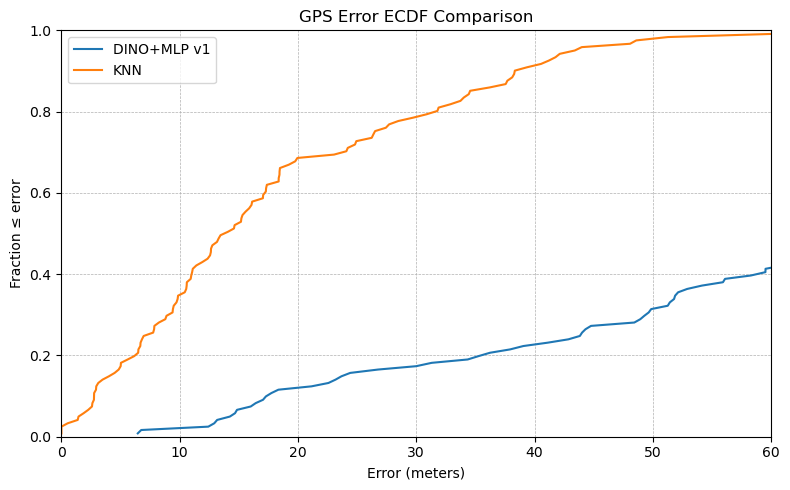

/tmp/ipykernel_4001121/1988519677.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


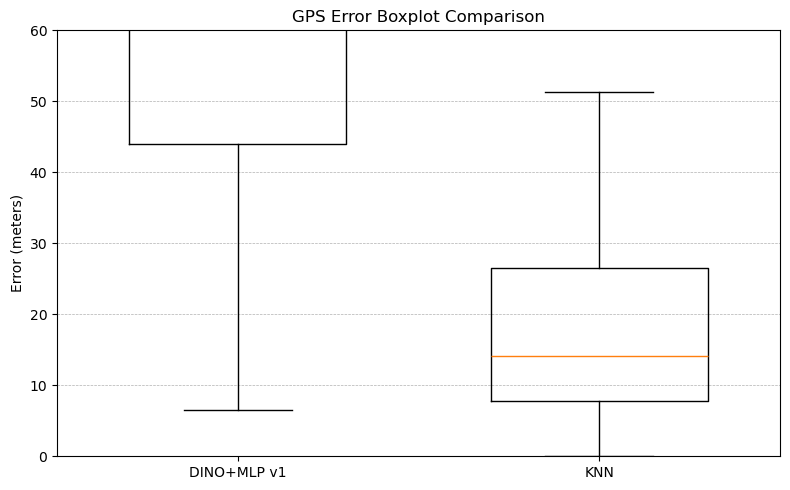

      model   mean_m  median_m      p90_m      p95_m      max_m  within_10m_%  within_25m_%  within_50m_%  within_100m_%  within_250m_%  within_500m_%  within_1000m_%
        KNN 18.50365 14.066312  38.333295  43.402639 115.883805     34.710744     72.727273     97.520661      99.173554     100.000000          100.0           100.0
DINO+MLP v1 94.28518 80.343696 186.099635 219.929850 312.485846      1.652893     15.702479     31.404959      61.983471      99.173554          100.0           100.0


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_models_gps(
    models,
    dataset,
    GPS_norm=None,
    dataset_returns="norm",
    model_returns="norm",
    batch_size=32,
    device="cuda",
    max_samples=None,
    thresholds=(10, 25, 50, 100, 250, 500, 1000),
    plot_ecdf=True,
    plot_box=False,
):
    """
    models: list of (name, model) OR list of models (then names auto-generated)
    returns: (df_summary, errors_by_model)
      - df_summary: pandas DataFrame of metrics per model
      - errors_by_model: dict[name] -> np.array errors_m
    """

    # Normalize input to list of (name, model)
    if len(models) == 0:
        raise ValueError("models list is empty")

    if isinstance(models[0], tuple) and len(models[0]) == 2:
        named_models = models
    else:
        named_models = [(f"model_{i}", m) for i, m in enumerate(models)]

    rows = []
    errors_by_model = {}

    for name, model in named_models:
        # make sure eval mode
        if hasattr(model, "eval"):
            model.eval()

        metrics, errors_m = evaluate_gps_meters_batched(
            model=model,
            dataset=dataset,
            max_samples=max_samples,
            GPS_norm=GPS_norm,
            dataset_returns=dataset_returns,
            model_returns=model_returns,
            batch_size=batch_size,
            device=device,
        )

        errors_by_model[name] = errors_m

        # flatten metrics into one row
        row = {"model": name}
        row.update(metrics)

        # ensure threshold columns exist in a consistent order (your evaluate already adds within_*m_%)
        # but we’ll enforce ordering later in the DataFrame
        rows.append(row)

    df = pd.DataFrame(rows)

    # Order columns nicely
    base_cols = ["model", "mean_m", "median_m", "p90_m", "p95_m", "max_m"]
    thr_cols = [f"within_{t}m_%" for t in thresholds if f"within_{t}m_%" in df.columns]
    df = df[base_cols + thr_cols]

    # Sort by median (or mean)
    df = df.sort_values("median_m", ascending=True).reset_index(drop=True)

    # ---------- Plots ----------
    if plot_ecdf:
        plt.figure(figsize=(8, 5))

        for name, _ in named_models:
            e = np.sort(errors_by_model[name])
            y = np.arange(1, len(e) + 1) / len(e)
            plt.plot(e, y, label=name)

        # LINEAR SCALE (not log)
        plt.xscale("linear")

        # Explicit ticks
        plt.xticks([0, 10, 20, 30, 40, 50, 60])

        plt.xlim(0, 60)   # optional but recommended for clarity
        plt.ylim(0, 1.0)

        plt.xlabel("Error (meters)")
        plt.ylabel("Fraction ≤ error")
        plt.title("GPS Error ECDF Comparison")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    if plot_box:
        plt.figure(figsize=(8, 5))

        labels = [name for name, _ in named_models]
        data = [errors_by_model[name] for name in labels]

        plt.boxplot(
            data,
            labels=labels,
            showfliers=False,   # hides extreme outliers (recommended)
            widths=0.6,
        )

        # LINEAR SCALE
        plt.yscale("linear")

        # Explicit ticks
        plt.yticks([0, 10, 20, 30, 40, 50, 60])

        plt.ylim(0, 60)

        plt.ylabel("Error (meters)")
        plt.title("GPS Error Boxplot Comparison")
        plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()


    return df, errors_by_model

models = [
    ("DINO+MLP v1", dinoMLP_model),
    ("KNN", db2),
]

df, errors = compare_models_gps(
    models=models,
    dataset=val_dataset,
    GPS_norm=GPS_norm,
    dataset_returns="norm",
    model_returns="norm",
    batch_size=32,
    device="cuda",
    max_samples=125,
    plot_ecdf=True,
    plot_box=True,
)

print(df.to_string(index=False))



# Visualize

Sampling 12 samples from dataset
predicting...
DONE!


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


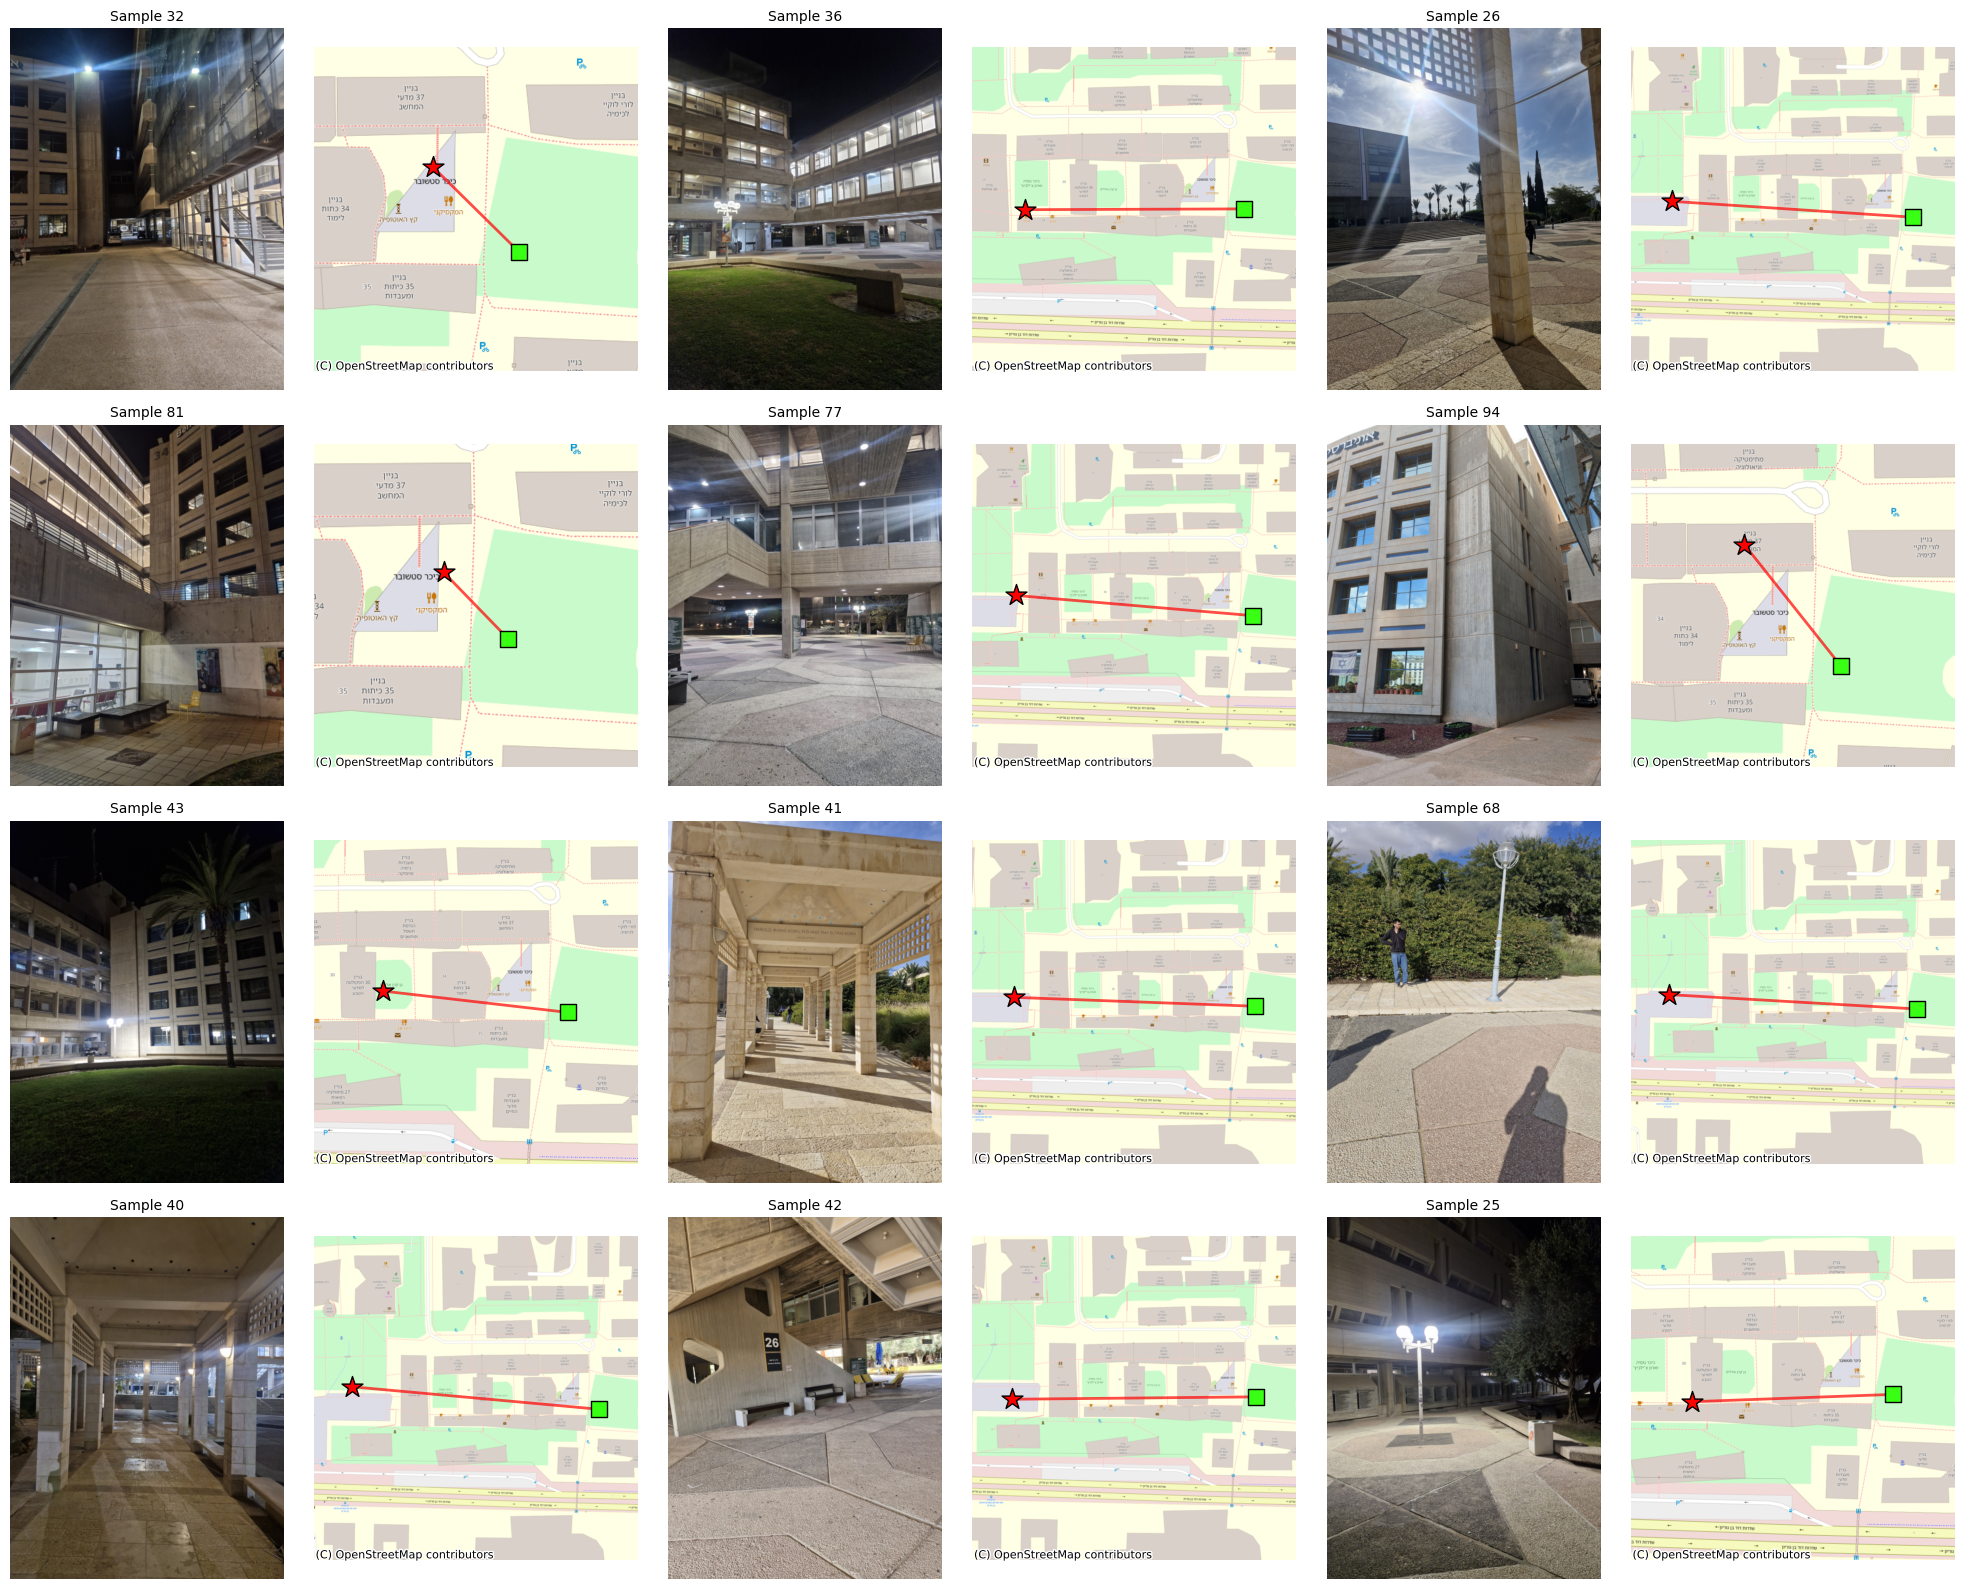

In [20]:
# from visualization import visualize_model_predictions
visualize_model_predictions(dinoMLP_model, val_dataset, GPS_norm)

In [6]:
import matplotlib.pyplot as plt
from pyproj import Transformer
import contextily as ctx

def _plot_map_panel(ax, gt_merc, pred_merc, nn_mercs=None, pad_m=50, zoom=19):
    # 1. Set Bounds (include GT, Pred, and all Neighbors)
    all_x = [gt_merc[0], pred_merc[0]] + ([x for x, y in nn_mercs] if nn_mercs else [])
    all_y = [gt_merc[1], pred_merc[1]] + ([y for x, y in nn_mercs]if nn_mercs else [])

    ax.set_xlim(min(all_x) - pad_m, max(all_x) + pad_m)
    ax.set_ylim(min(all_y) - pad_m, max(all_y) + pad_m)

    # 2. Add Background Map
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except Exception as e:
        print(f"Map fetch failed: {e}")

    # --- DRAW LINES FIRST (so they appear under dots) ---
    
    # Line: GT -> Prediction (Solid Red Line)
    ax.plot([gt_merc[0], pred_merc[0]], [gt_merc[1], pred_merc[1]], 
            color='red', linestyle='-', linewidth=2, alpha=0.7, zorder=4)

    # Lines: GT -> Neighbors (Thin Dashed Blue Lines)
    if nn_mercs:
        for x, y in nn_mercs:
            ax.plot([gt_merc[0], x], [gt_merc[1], y], 
                    color='blue', linestyle='--', linewidth=0.8, alpha=0.6, zorder=3)

    # --- DRAW MARKERS ---

    # 3. Ground Truth: Red Star
    ax.scatter(gt_merc[0], gt_merc[1], s=250, marker="*", 
               c='red', edgecolors='black', zorder=10, label='GT')
    ax.text(gt_merc[0], gt_merc[1], " GT", fontsize=11, fontweight='bold', zorder=12)

    # 4. Prediction: Green Square
    ax.scatter(pred_merc[0], pred_merc[1], s=120, marker="s", 
               c='#39FF14', edgecolors='black', zorder=9, label='Pred') # Neon Green
    ax.text(pred_merc[0], pred_merc[1], " Pred", fontsize=9, fontweight='bold', zorder=12)

    if nn_mercs:
        # 5. Neighbors: Blue Circles
        for i, (x, y) in enumerate(nn_mercs, 1):
            ax.scatter(x, y, s=100, marker="o", 
                    c='cyan', edgecolors='black', zorder=8)
            ax.text(x, y, f" {i}", fontsize=8, zorder=12)

    ax.set_title(f"Spatial Distribution (GT vs Pred{' vs NN' if nn_mercs else ''})", fontsize=9)
    ax.axis("off")


In [4]:
import numpy as np
import torch


# Web Mercator transformer (degrees -> meters)
_transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def latlon_to_mercator(lat_deg, lon_deg):
    x, y = _transformer.transform(lon_deg, lat_deg)
    return x, y

# ----------------------------
# Distance helpers (expects DEGREES!)
# ----------------------------
def haversine_m(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371000.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1_deg, lon1_deg, lat2_deg, lon2_deg])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def _to_numpy_image(img, mean=None, std=None):
    if isinstance(img, torch.Tensor):
        x = img.detach().cpu()
        if x.ndim == 3 and x.shape[0] == 3:
            x = x.permute(1, 2, 0)  # HWC
        x = x.float().numpy()
    else:
        x = np.array(img)

    if mean is not None and std is not None:
        mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3)
        std = np.array(std, dtype=np.float32).reshape(1, 1, 3)
        x = x * std + mean

    if x.max() > 1.5:
        x = x / 255.0

    return np.clip(x, 0.0, 1.0).astype(np.float32)

def _format_gps(gps):
    if isinstance(gps, torch.Tensor):
        gps = gps.detach().cpu().tolist()
    return float(gps[0]), float(gps[1])

def _get_match_fields(m):
    idx = getattr(m, "idx", None)
    score = getattr(m, "score", None)
    gps = getattr(m, "gps", None)
    return idx, score, gps

# ----------------------------
# Main visualization
# ----------------------------
def plot_queries_with_topk_matches_and_map(
    db : SaladFaissGPSDB,
    test_dataset,
    train_dataset=None,
    GPS_norm=None,               # MUST provide (has .decode)
    n=5,
    k=3,
    weighted=True,
    mean=None, std=None,
    figsize_per_row=(16, 4),
    pad_m=50,
    zoom=19,
):
    """
    Shows per row:
      [Query image] [NN1] [NN2] [NN3] ... [Map]

    Titles print NORMALIZED GPS only.
    Distances + map use DECODED GPS internally.
    """

    if GPS_norm is None:
        raise ValueError("GPS_norm must be provided (object with .decode(lat_n, lon_n)->(lat_deg, lon_deg))")

    n = min(n, len(test_dataset))
    cols = k + 2  # Query + k matches + Map
    fig = plt.figure(figsize=(figsize_per_row[0], figsize_per_row[1] * n))

    def clamp01(a, b):
        return float(np.clip(a, 0.0, 1.0)), float(np.clip(b, 0.0, 1.0))

    for row in range(n):
        query_img, query_gps = test_dataset[row]

        # GT normalized (what we PRINT)
        gt_lat_n, gt_lon_n = _format_gps(query_gps)
        gt_lat_n, gt_lon_n = clamp01(gt_lat_n, gt_lon_n)

        # GT decoded (what we USE for meters/map)
        gt_lat_d, gt_lon_d = GPS_norm.decode(gt_lat_n, gt_lon_n)

        # Original idx in full_dataset if Subset
        orig_idx = test_dataset.indices[row] if hasattr(test_dataset, "indices") else row

        # Predict normalized (db built on normalized gps)
        with torch.no_grad():
            pred_lat_n, pred_lon_n = db.predict_gps(query_img, k=max(k, 5), weighted=weighted)
        pred_lat_n, pred_lon_n = clamp01(float(pred_lat_n), float(pred_lon_n))
        pred_lat_d, pred_lon_d = GPS_norm.decode(pred_lat_n, pred_lon_n)

        pred_err_m = haversine_m(gt_lat_d, gt_lon_d, pred_lat_d, pred_lon_d)

        # Query panel
        ax = plt.subplot(n, cols, row * cols + 1)
        ax.imshow(_to_numpy_image(query_img, mean=mean, std=std))
        ax.axis("off")
        ax.set_title(
            f"QUERY split#{row} orig#{orig_idx + 1}\n"
            f"GT (norm):   ({gt_lat_d:.4f},{gt_lon_d:.4f})\n"
            f"PRED (norm): ({pred_lat_d:.4f},{pred_lon_d:.4f})\n"
            f"Pred err: {pred_err_m:.1f} m",
            fontsize=9
        )

        # Get matches (their gps is normalized)
        matches = db.query_image(query_img, k=k)

        # Collect decoded mercator points for map bounds
        gt_merc = latlon_to_mercator(gt_lat_d, gt_lon_d)
        pred_merc = latlon_to_mercator(pred_lat_d, pred_lon_d)

        gx, gy = gt_merc
        all_x = [gx]
        all_y = [gy]
        nn_xy = []

        # NN panels
        for j in range(k):
            axm = plt.subplot(n, cols, row * cols + 1 + (j + 1))

            if j >= len(matches):
                axm.axis("off")
                axm.set_title(f"NN{j+1}\n(no match)", fontsize=9)
                continue

            m = matches[j]
            idx, score, mgps = _get_match_fields(m)

            # Match gps normalized for PRINT, decoded for meters/map
            if mgps is not None:
                mlat_n, mlon_n = _format_gps(mgps)
                mlat_n, mlon_n = clamp01(mlat_n, mlon_n)
                mlat_d, mlon_d = GPS_norm.decode(mlat_n, mlon_n)
                geo_m = haversine_m(gt_lat_d, gt_lon_d, mlat_d, mlon_d)

                x, y = latlon_to_mercator(mlat_d, mlon_d)
                nn_xy.append((x, y))
                all_x.append(x)
                all_y.append(y)
            else:
                mlat_n = mlon_n = None
                geo_m = None

            # Show match image if possible
            if train_dataset is not None and idx is not None:
                try:
                    mimg, _ = train_dataset[idx]
                    axm.imshow(_to_numpy_image(mimg, mean=mean, std=std))
                    axm.axis("off")
                except Exception:
                    axm.axis("off")
                    axm.text(0.5, 0.5, f"train_dataset[{idx}] failed", ha="center", va="center")
            else:
                axm.axis("off")
                axm.text(0.5, 0.5, "No train image", ha="center", va="center")

            score_str = "NA" if score is None else f"{float(score):.4f}"
            geo_str = "NA" if geo_m is None else f"{geo_m:.1f} m"
            gps_norm_str = "NA" if mlat_n is None else f"({mlat_n:.4f},{mlon_n:.4f})"

            axm.set_title(
                f"NN{j+1} idx={idx}\n"
                f"emb_score={score_str}\n"
                f"gps(norm)={gps_norm_str}\n"
                f"GT→NN geo={geo_str}",
                fontsize=9
            )

        # Map panel (decoded only)
        ax_map = plt.subplot(n, cols, row * cols + cols)

        _plot_map_panel(ax_map, gt_merc, pred_merc, nn_xy)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Example usage:
# ----------------------------
plot_queries_with_topk_matches_and_map(
    db=db2,
    test_dataset=val_dataset,
    train_dataset=train_dataset,
    GPS_norm=GPS_norm,  
    n=10,
    k=5,
    weighted=True,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    pad_m=50,
    zoom=19
)


NameError: name 'Transformer' is not defined

In [ ]:
from data.extract_gps import extract_gps


print(extract_gps(r"C:\Users\PC\Desktop\Works\semester g\Deep\Image2GPS-Deep\data\temp\20260113_152942.jpg"))
extract_gps(r"data\indexed_photos\179.jpg")

Error extracting GPS from C:\Users\PC\Desktop\Works\semester g\Deep\Image2GPS-Deep\data\temp\20260113_152942.jpg: [Errno 2] No such file or directory: 'C:\\Users\\PC\\Desktop\\Works\\semester g\\Deep\\Image2GPS-Deep\\data\\temp\\20260113_152942.jpg'
None


(31.261939399722223, 34.80447509972222)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_query_and_nn_map(db, test_dataset, idx=0, k=3):
    """
    Plots a lat/lon scatter "mini-map" for:
      - query (ground truth)
      - query prediction (optional)
      - k nearest neighbors GPS locations

    Assumes:
      - test_dataset[idx] -> (img, gps) with gps=[lat,lon]
      - db.query_image(img,k) -> list of matches with .gps and optional .score
      - db.predict_gps(img, ...) -> (lat, lon)
    """

    img, gt_gps = test_dataset[idx]
    gt_lat, gt_lon = gt_gps.detach().cpu().tolist() if isinstance(gt_gps, torch.Tensor) else gt_gps

    # NN matches
    matches = db.query_image(img, k=k)
    nn_lats, nn_lons, nn_scores = [], [], []
    for m in matches:
        mgps = getattr(m, "gps", None)
        if mgps is None:
            continue
        mlat, mlon = mgps.detach().cpu().tolist() if isinstance(mgps, torch.Tensor) else mgps
        nn_lats.append(float(mlat))
        nn_lons.append(float(mlon))
        nn_scores.append(getattr(m, "score", None))

    # Optional prediction point
    with torch.no_grad():
        pred_lat, pred_lon = db.predict_gps(img, k=max(5, k), weighted=True)

    # ---- Plot ----
    plt.figure(figsize=(7, 7))

    # Neighbors
    if len(nn_lats) > 0:
        plt.scatter(nn_lons, nn_lats, marker="o", label="Nearest neighbors (train)", s=80)
        # label each neighbor with rank
        for i, (lo, la) in enumerate(zip(nn_lons, nn_lats), start=1):
            plt.text(lo, la, f"  NN{i}", fontsize=10)

    # Query GT
    plt.scatter([gt_lon], [gt_lat], marker="*", label="Query GT (test)", s=220)

    # Query prediction
    plt.scatter([pred_lon], [pred_lat], marker="x", label="Query predicted", s=120)

    # Nice view: zoom around query + neighbors
    all_lats = [gt_lat] + nn_lats + [float(pred_lat)]
    all_lons = [gt_lon] + nn_lons + [float(pred_lon)]
    lat_min, lat_max = min(all_lats), max(all_lats)
    lon_min, lon_max = min(all_lons), max(all_lons)

    # add a small margin
    lat_pad = (lat_max - lat_min) * 0.25 + 1e-6
    lon_pad = (lon_max - lon_min) * 0.25 + 1e-6
    plt.xlim(lon_min - lon_pad, lon_max + lon_pad)
    plt.ylim(lat_min - lat_pad, lat_max + lat_pad)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Query test sample #{idx} + {k} nearest neighbors")
    plt.grid(True)
    plt.legend()
    plt.show()
#plot_query_and_nn_map(db2, val_dataset, idx=0, k=3)



In [ ]:
import folium
import torch


def plot_query_and_nn_real_map(
    db,
    test_dataset,
    idx=0,
    k=3,
    weighted=True,
    out_html="nn_map.html",
    zoom_start=18
):
    """
    Creates an interactive real map (Folium) with:
      - Query GT (star marker)
      - Query prediction (blue marker)
      - k nearest neighbors (numbered markers)
      - Lines from query GT to each NN

    Saves to out_html and also returns the folium.Map object.
    """

    # --- get query ---
    img, gt_gps = test_dataset[idx]
    if isinstance(gt_gps, torch.Tensor):
        gt_lat, gt_lon = gt_gps.detach().cpu().tolist()
    else:
        gt_lat, gt_lon = gt_gps

    # --- predict gps ---
    with torch.no_grad():
        pred_lat, pred_lon = db.predict_gps(img, k=max(k, 5), weighted=weighted)

    # --- nearest neighbors ---
    matches = db.query_image(img, k=k)

    nn_points = []
    for rank, m in enumerate(matches, start=1):
        mgps = getattr(m, "gps", None)
        if mgps is None:
            continue
        if isinstance(mgps, torch.Tensor):
            mlat, mlon = mgps.detach().cpu().tolist()
        else:
            mlat, mlon = mgps
        score = getattr(m, "score", None)
        midx = getattr(m, "idx", None)
        nn_points.append((rank, float(mlat), float(mlon), score, midx))

    # --- build map centered at GT ---
    m = folium.Map(location=[gt_lat, gt_lon], zoom_start=zoom_start, control_scale=True)

    # Query GT marker
    folium.Marker(
        location=[gt_lat, gt_lon],
        popup=f"Query GT (test #{idx})\n({gt_lat:.6f}, {gt_lon:.6f})",
        tooltip="Query GT",
        icon=folium.Icon(color="red", icon="star")
    ).add_to(m)

    # Prediction marker
    folium.Marker(
        location=[float(pred_lat), float(pred_lon)],
        popup=f"Prediction\n({float(pred_lat):.6f}, {float(pred_lon):.6f})",
        tooltip="Prediction",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    # Neighbors markers + lines
    for rank, lat, lon, score, midx in nn_points:
        popup = f"NN{rank} idx={midx} score={score}\n({lat:.6f}, {lon:.6f})"
        folium.Marker(
            location=[lat, lon],
            popup=popup,
            tooltip=f"NN{rank}",
            icon=folium.Icon(color="green", icon="ok-sign")
        ).add_to(m)

        # line from GT to neighbor
        folium.PolyLine(
            locations=[[gt_lat, gt_lon], [lat, lon]],
            weight=3,
            opacity=0.8
        ).add_to(m)

    # Also line from GT to prediction
    folium.PolyLine(
        locations=[[gt_lat, gt_lon], [float(pred_lat), float(pred_lon)]],
        weight=3,
        opacity=0.8
    ).add_to(m)

    m.save(out_html)
    print(f"Saved map to: {out_html}  (open it in your browser)")
    return m

plot_query_and_nn_real_map(db2, val_dataset, idx=1, k=2, out_html="nn_map_0.html")


ModuleNotFoundError: No module named 'folium'